# Cross-Validation & Regularization

In [1]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression,\
LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split, KFold,\
cross_val_score, cross_validate, ShuffleSplit
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

One of the goals of a machine learning project is to make models which are highly predictive.
If the model fails to generalize to unseen data then the model is bad.

## Review of Earlier concepts

### Overfitting vs Underfitting
    1. Underfit models fail to capture all of the information in the data
        1. Ex. Just predicting the mean leaves a lot of information on the table
    2. Overfit models fit to the noise in the data and fail to generalize
    3. How would we know if our model is over- or underfit?
        1. Train test split
        2. Look at the testing error
        3. As model complexity increases so does the possibility for overfitting

### Bias-Variance Tradeoff
    1. High bias
        1. Systematic error in predictions
        2. Bias is about the strength of assumptions the model makes
        3. Underfit models tend to have high bias
    2. High variance
        1. The model is highly sensitive to changes in the data
        2. Overfit models tend to have low bias

#### Example

High bias is easy to wrap one's mind around: Imagine pulling three red balls from an urn that has hundreds of balls of all colors in a uniform distribution. Then my sample is a terrible representative of the whole population. If I were to build a model by extrapolating from my sample, that model would predict that _every_ ball produced would be red! That is, this model would be incredibly biased.

High variance is a little bit harder to visualize, but it's basically the "opposite" of this. Imagine that the population of balls in the urn is mostly red, but also that there are a few balls of other colors floating around. Now imagine that our sample comprises a few balls, none of which is red. In this case, we've essentially picked up on the "noise", rather than the "signal". If I were to build a model by extrapolating from my sample, that model would be needlessly complex. It might predict that balls drawn before noon will be orange and that balls drawn after 8pm will be green, when the reality is that a simple model that predicted 'red' for all balls would be a superior model!

The important idea here is that there is a *trade-off*: If we have too few data in our sample (training set), or too few predictors, we run the risk of high *bias*, i.e. an underfit model. On the other hand, if we have too many predictors (especially ones that are collinear), we run the risk of high *variance*, i.e. an overfit model.

[Here](https://en.wikipedia.org/wiki/Overfitting#/media/File:Overfitting.svg) is a nice illustration of the difficulty.

## Validation

So: You've split your data in two, reserving one piece for training your model and the other for testing it after it's built. That's good!

But generally speaking we want to take more precautions than this. After all, we're still imagining building just one model on the training set and then crossing our fingers for its performance on the test set.

Data scientists often distinguish *three* subsets of data: training, **validation**, and testing.

Roughly:
- Training data is for building the model;
- Validation data is for *tweaking* the model;
- Testing data is for evaluating the model on unseen data.

This "tweaking" includes most of all the fine-tuning of model parameters (see below). Think of what this three-way distinction allows us to do:

I can build a model on some data. Then, **before** I introduce the model to the testing data, I can introduce it to a different batch of data (the validation set). With respect to the validation data I can do things like measure error and tweak model parameters to minimize that error. Of course, I also don't want to lose sight of the error on the training data. If the model error has been minimized on the training error, then of course any changes I make to the model parameters will take me away from that minimum. But still the new information I've gained by looking at the model's performance on the validiation data is valuable. I might for example go with a kind of compromising model whose parameters produce an error that's not too big on the training data and not too big on the validation data.

**Question**: What's different about this procedure from what we've described before? Aren't I just calling the test data "validation data" now? Is there any substantive difference?

### From Validation to Cross-Validation

Since my model will "see" the validation data in any case, I might as well use *all* of my training data to validate my model! How do I do this?

Cross-validation works like this: First I'll partition my training data into $k$-many *folds*. Then I'll train a model on $k-1$ of those folds and "test" it on the remaining fold. I'll do this for all possible divisions of my $k$ folds into $k-1$ training folds and a single "testing" fold. Since there are $k\choose 1$$=k$-many ways of doing this, I'll be building $k$-many models!

#### In Python

In [2]:
birds = sns.load_dataset('penguins')
birds.sample(5)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
34,Adelie,Dream,36.4,17.0,195.0,3325.0,Female
160,Chinstrap,Dream,46.0,18.9,195.0,4150.0,Female
171,Chinstrap,Dream,49.2,18.2,195.0,4400.0,Male
226,Gentoo,Biscoe,45.4,14.6,211.0,4800.0,Female
105,Adelie,Biscoe,39.7,18.9,184.0,3550.0,Male


In [3]:
birds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [4]:
# For simplicity's sake we'll limit our analysis to the numeric columns.

numeric = birds[['bill_length_mm', 'bill_depth_mm',
                 'flipper_length_mm', 'body_mass_g']]

In [5]:
# We'll drop the rows with null values

numeric = numeric.dropna().reset_index()

Initiating the `KFold()` object

In [6]:
folds = KFold(n_splits=10, shuffle=True, random_state=42)

In [7]:
folds.split(numeric)

<generator object _BaseKFold.split at 0x7fdf1937a200>

In [8]:
[bird for bird in folds.split(numeric)]

[(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  40,  41,
          43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  56,
          57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
          70,  71,  72,  73,  74,  75,  76,  77,  79,  80,  81,  82,  83,
          84,  85,  86,  87,  88,  89,  91,  92,  93,  94,  95,  96,  97,
          98,  99, 100, 101, 102, 103, 105, 106, 107, 110, 111, 112, 114,
         115, 117, 120, 121, 122, 123, 125, 127, 128, 129, 130, 131, 132,
         133, 134, 135, 136, 137, 138, 140, 141, 142, 143, 144, 146, 148,
         149, 150, 151, 153, 154, 155, 156, 158, 159, 160, 161, 162, 163,
         164, 165, 166, 167, 168, 169, 170, 171, 173, 174, 175, 176, 178,
         180, 181, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
         194, 195, 196, 197, 198, 199,

Suppose I want to model `body_mass_g` as a function of the other attributes.

In [9]:
X = numeric.drop('body_mass_g', axis=1)
y = numeric['body_mass_g']

We'll make ten models and record our evaluations of them.

In [10]:
r2_scores = np.array([])

# For each partition in our list:
for train, test in folds.split(numeric):
    
    # We'll train a model on the nine-fold part ...
    X_training = X.loc[train, :]
    
    # and test it on the fold left over.
    X_testing = X.loc[test, :]
    y_training = y.loc[train]
    y_testing = y.loc[test]
    lr = LinearRegression()
    lr.fit(X_training, y_training)
    
    # We'll keep track of all of the R^2 scores.
    r2_score = lr.score(X_testing, y_testing)
    r2_scores = np.append(r2_scores, r2_score)

In [11]:
r2_scores

array([0.76372528, 0.80504898, 0.87944779, 0.69166536, 0.70598945,
       0.7906891 , 0.79012162, 0.7056888 , 0.72420133, 0.6897163 ])

In [12]:
r2_scores.mean()

0.754629400106592

In [13]:
lr2 = LinearRegression()

In [14]:
cv = ShuffleSplit(random_state=42)

In [15]:
cross_validate(estimator=lr2, X=X, y=y, cv=cv) # The 'cv' parameter can
                                               # also take an integer value

{'fit_time': array([0.00205302, 0.00201607, 0.00165105, 0.00163674, 0.00165606,
        0.00161815, 0.00158381, 0.00185108, 0.00156617, 0.00155115]),
 'score_time': array([0.0012691 , 0.00127196, 0.00120091, 0.00125313, 0.00121403,
        0.00119305, 0.00118184, 0.00117207, 0.00115681, 0.00115776]),
 'test_score': array([0.76372528, 0.81616757, 0.84007876, 0.83198796, 0.77269637,
        0.80569558, 0.75906669, 0.87606477, 0.79324728, 0.80781073])}

In [16]:
cross_validate(estimator=lr2, X=X, y=y, cv=cv)['test_score']

array([0.76372528, 0.81616757, 0.84007876, 0.83198796, 0.77269637,
       0.80569558, 0.75906669, 0.87606477, 0.79324728, 0.80781073])

In [17]:
cross_validate(estimator=lr2, X=X, y=y, cv=cv)['test_score'].mean()

0.8066540989013976

## Regularization - a way to prevent overfitting
    - Types of regularization
        1. Reducing the number of features
        2. Increasing the amount of data
        3. Ridge, Lasso, Elastic Net
        
Again, complex models are very flexible in the patterns that they can model but this also means that they can easily find patterns that are simply statistical flukes of one particular dataset rather than patterns reflective of the underlying data-generating process.

### The Strategy Behind Ridge / Lasso / Elastic Net

Overfit models overestimate the relevance that predictors have for a target. Thus overfit models tend to have **overly large coefficients**.

The evaluation of many models, linear regression included, proceeds by measuring its **error**, some quantifiable expression of the discrepancy between its predictions and the ground truth. The best-fit line of LR, for example, minimizes the sum of squared residuals.

Our new idea, then, will be ***to add a term representing the size of our coefficients to our loss function***.

The goal will still be to minimize this new function, but we can make progress toward this minimum *either* by reducing the size of our residuals *or* by reudcing the size of our coefficients.

Since coefficients can be either negative or positive, we have the familiar difficulty that we can't simply add them up to get a sense of how large they are in general. Once again there are two natural choices: We could focus either on the squares or the absolute values of the coefficients. The former strategy is the basis for **Ridge** (also called Tikhonov) regularization; the latter strategy results in **LASSO** (Least Absolute Shrinkage and Selection Operator) regularization.

These tools, as we shall see, are easily implemented with `sklearn`.

#### Changing Our Loss Function

Overfitting is generally a result of high model variance. High model variance can be caused by:
- having irrelevant or too many predictors
- multicollinearity
- large coefficients

The first problem is about picking up on noise rather than signal.
The second problem is about having a least-squares estimate that is highly sensitive to random error.
The third is about having highly sensitive predictors.

Regularization is about introducing a factor into our model designed to enforce the stricture that the coefficients stay small, by penalizing the ones that get too large.

That is, we'll alter our loss function so that the goal now is not merely to minimize the difference between actual values and our model's predicted values. Rather, we'll add in a term to our loss function that represents the sizes of the coefficients.

There are two popular ways of doing this:

Lasso ("L1"): Minimize $\large\Sigma^{n_{obs.}}_{i=1}[(y_i - \Sigma^{n_{feat.}}_{j=0}\beta_j\times x_{ij})^2 + \lambda\Sigma^{n_{feat.}}_{j=0}|\beta_j|]$
<br/> <br/>

Ridge ("L2"): Minimize $\large\Sigma^{n_{obs.}}_{i=1}[(y_i - \Sigma^{n_{feat.}}_{j=0}\beta_j\times x_{ij})^2 + \lambda\Sigma^{n_{feat.}}_{j=0}\beta^2_j]$

**$\rightarrow$ Don't let these formulas be intimidating.** The first term in each of these (the sum of squares) is the same, and is just the familiar loss function that we've always used. What distinguishes the Lasso Regression from the Ridge Regression is only the extra term on the right. The Lasso uses the absolute values of the coefficients, while the Ridge uses the squares of the coefficients.

**When should I use each of these?**

- For a given value of $\lambda$, the ridge makes for a gentler reining in of runaway coefficients. When in doubt, try ridge first.
- The lasso will more quickly reduce the contribution of individual predictors down to insignificance. It is therefore most useful for trimming through the fat of datasets with many predictors or if a model with very few predictors is especially desirable.

For a nice discussion of these methods in Python, see [this post](https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b).

### A quick comparison

Below, we create some fake data. 

The first columns as our true predictor, and the second column is random noise. The third column is our target.

In [18]:
data = np.array([
                [1, 1, 5],
                [2, 2, 4],
                [3, 1, 3],
                [4, 3, 2],
                [5, 1, 1],
               ])
X, y = data[:,:2], data[:,2]
X = X.reshape((len(X), 2))

In [19]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X,y)
print('No Regularization coeff:', model.coef_)
print('No Regularization intercept:', model.intercept_)

No Regularization coeff: [-1.00000000e+00  7.02166694e-17]
No Regularization intercept: 6.000000000000001


In [20]:
from sklearn.linear_model import Lasso
lasso = Lasso()
lasso.fit(X,y)
print('Lasso coeff:', lasso.coef_)
print('Lasso intercept:', lasso.intercept_)

Lasso coeff: [-0.5 -0. ]
Lasso intercept: 4.5


In [21]:
from sklearn.linear_model import Ridge
ridge = Ridge()
ridge.fit(X,y)
print('ridge coeff:', ridge.coef_)
print('ridge intercept:', ridge.intercept_)

ridge coeff: [-0.90707965 -0.02212389]
ridge intercept: 5.756637168141593


## Ridge and Lasso Regression

### Producing an Overfit Model

We can often produce an overfit model by including **interaction terms**. We'll start over with the penguins dataset. This time we'll include the categorical features.

#### Train-Test Split

In [22]:
birds = birds.dropna()

In [23]:
X = birds.drop('body_mass_g', axis=1)
y = birds['body_mass_g']
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                   random_state=42)

In [24]:
ohe = OneHotEncoder(drop='first')
dummies = ohe.fit_transform(X_train[['species', 'island', 'sex']])
dummies_df = pd.DataFrame(dummies.todense(), columns=ohe.get_feature_names(),
                         index=X_train.index)
X_train_df = pd.concat([X_train[['bill_length_mm', 'bill_depth_mm',
                                'flipper_length_mm']], dummies_df], axis=1)
X_train_df.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,x0_Chinstrap,x0_Gentoo,x1_Dream,x1_Torgersen,x2_Male
321,55.9,17.0,228.0,0.0,1.0,0.0,0.0,1.0
265,43.6,13.9,217.0,0.0,1.0,0.0,0.0,0.0
36,38.8,20.0,190.0,0.0,0.0,1.0,0.0,1.0
308,47.5,14.0,212.0,0.0,1.0,0.0,0.0,0.0
191,53.5,19.9,205.0,1.0,0.0,1.0,0.0,1.0


#### First simple model

In [25]:
test_dummies = ohe.transform(X_test[['species', 'island', 'sex']])
test_df = pd.DataFrame(test_dummies.todense(), columns=ohe.get_feature_names(),
                       index=X_test.index)
X_test_df = pd.concat([X_test[['bill_length_mm', 'bill_depth_mm',
                              'flipper_length_mm']], test_df], axis=1)

In [26]:
lr1 = LinearRegression()
lr1.fit(X_train_df, y_train)

pens_preds = lr1.predict(X_test_df)

In [27]:
lr1.score(X_train_df, y_train)

0.8688983108974326

In [28]:
lr1.score(X_test_df, y_test)

0.893422869342433

In [29]:
np.sqrt(mean_squared_error(pens_preds, y_test))

253.98121177477864

#### Add Polynomial Features

In [30]:
pf = PolynomialFeatures(degree=3)
X_poly_train = pf.fit_transform(X_train_df)

In [31]:
poly_lr = LinearRegression()
poly_lr.fit(X_poly_train, y_train)

LinearRegression()

In [32]:
X_poly_test = pf.transform(X_test_df)
poly_preds = poly_lr.predict(X_poly_test)

In [33]:
poly_lr.score(X_poly_train, y_train)

0.892983754432947

That's an improvement in $R^2$ on the training data. Let's check the score on the test data.

In [34]:
poly_lr.score(X_poly_test, y_test)

-1.0339222509974437

Ugh! What happened?

In [35]:
np.sqrt(mean_squared_error(poly_preds, y_test))

1109.5241328239642

In a word, we've overfit our model. Let's see if ridge regularization can help.

### Ridge (L2) Regression

In [36]:
ss = StandardScaler()
pf = PolynomialFeatures(degree=3)

# You should always be sure to _standardize_ your data before
# applying regularization!

X_train_processed = pf.fit_transform(ss.fit_transform(X_train_df))
X_test_processed = pf.transform(ss.transform(X_test_df))

'Lambda' is the standard variable for the strength of the
regularization (as in the above formulas), but since lambda
is a key word in Python, these sklearn regularization tools
use 'alpha' instead.

In [37]:
rr = Ridge(alpha=10, random_state=42)

rr.fit(X_train_processed, y_train)
ridge_preds = rr.predict(X_test_processed)

In [38]:
rr.score(X_train_processed, y_train)

0.8996018638606075

In [39]:
rr.score(X_test_processed, y_test)

0.8380772934500291

In [40]:
np.sqrt(mean_squared_error(ridge_preds, y_test))

313.0570268253131

Better than standard polynomial, but still performs worse than straight linear regression
 - Should determine which observations are being poorly predicted vs those that are being predicted well
 - Should also consider business case
 - Are there observations in the dataset that would cost significantly more to mispredict than others
 - Especially if predicting for medical or financial/economic purposes, the cost evaluations are easier to make

Much better! But how do we know which value of `alpha` to pick?

### Crossvalidation to Optimize the Regularization Hyperparameter

The regularization strength could sensibly be any nonnegative number, so there's no way to check "all possible" values. It's often useful to try several values that are different orders of magnitude.

In [41]:
alphas = np.linspace(.0001,1000,num=100)
train_scores = []
test_scores = []

for alpha in alphas:
    rr = Ridge(alpha=alpha, random_state=42)
    rr.fit(X_train_processed, y_train)
    train_score = rr.score(X_train_processed, y_train)
    test_score = rr.score(X_test_processed, y_test)
    
    train_scores.append(train_score)
    test_scores.append(test_score)

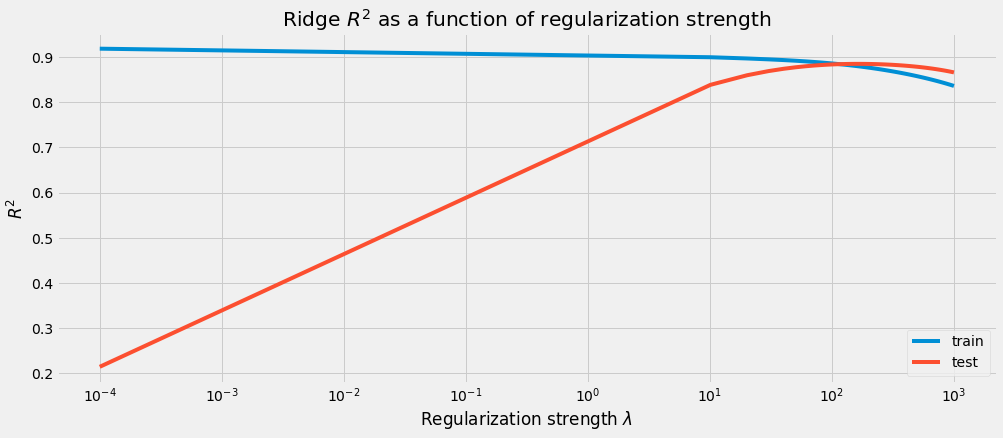

In [42]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(15,6))
plt.xscale('log')
plt.title('Ridge $R^2$ as a function of regularization strength')
ax.set_xlabel('Regularization strength $\lambda$')
ax.set_ylabel('$R^2$')
ax.plot(alphas, train_scores, label='train')
ax.plot(alphas, test_scores, label='test')
plt.legend();

It looks like the best value is somewhere around 100. If we wanted more precision, we could repeat the same sort of exercise with a set of alphas nearer to 100.

#### Observation
Notice how the values increase but then decrease? Regularization helps with overfitting, but if the strength of the regularization becomes too great, then large coefficients will be punished more than they really should. What happens then is that the original error between truth and model predictions becomes neglected as a quantity to be minimized, and the bias of the model begins to outweigh its variance.

### Lasso (L1) Regression

**Exercise**: Produce a similar plot using `Lasso` instead of `Ridge`!
    
    Hint: You may need to increase the value of the 'max_iter' parameter over the default.
    Level Up: Record the coefficients of each model to see how many go to 0 for each value of alpha.

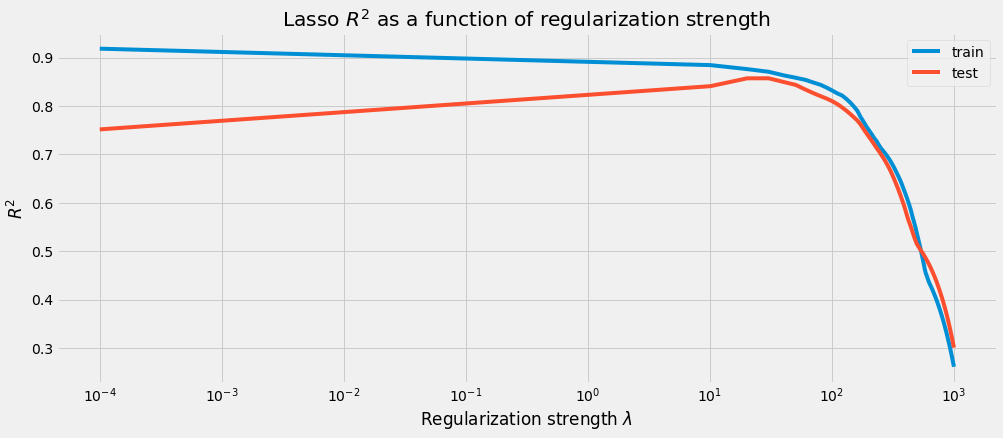

In [43]:
alphas = np.linspace(.0001,1000,num=100)
train_scores = []
test_scores = []
coefs = []


for alpha in alphas:                                          
    lr = Lasso(alpha=alpha, random_state=42, max_iter=100000, tol=.03)
                                                              # http://proceedings.mlr.press/v37/fercoq15.pdf
    lr.fit(X_train_processed, y_train)
    coefs.append(lr.coef_)
    train_score = lr.score(X_train_processed, y_train)
    test_score = cross_val_score(lr, X_test_processed, y_test, cv=3).mean()
    
    train_scores.append(train_score)
    test_scores.append(test_score)
    
fig, ax = plt.subplots(figsize=(15,6))
plt.xscale('log')
plt.title('Lasso $R^2$ as a function of regularization strength')
ax.set_xlabel('Regularization strength $\lambda$')
ax.set_ylabel('$R^2$')
ax.plot(alphas, train_scores, label='train')
ax.plot(alphas, test_scores, label='test')
plt.legend();

### Elastic Net

There is a combination of L1 and L2 regularization called the Elastic Net that can also be used. The idea is to use a scaled linear combination of the lasso and the ridge, where the weights add up to 100%. We might want 50% of each, but we also might want, say, 10% Lasso and 90% Ridge.

The loss function for an Elastic Net Regression looks like this:

Elastic Net: Minimize

$\rho\Sigma^{n_{obs.}}_{i=1}[(y_i - \Sigma^{n_{feat.}}_{j=0}\beta_j\times x_{ij})^2 + \lambda\Sigma^{n_{feat.}}_{j=0}|\beta_j|] + (1 - \rho)\Sigma^{n_{obs.}}_{i=1}[(y_i - \Sigma^{n_{feat.}}_{j=0}\beta_j\times x_{ij})^2 + \lambda\Sigma^{n_{feat.}}_{j=0}\beta^2_j]$

Sometimes you will see this loss function represented with different scaling terms, but the basic idea is to have a combination of L1 and L2 regularization terms.

#### Coding the Elastic Net

Naturally, the Elastic Net has the same interface through sklearn as the other regularization tools! The only difference is that we now have to specify how much of each regularization term we want. The name of the parameter for this (represented by $\rho$ above) in sklearn is `l1_ratio`.

In [44]:
enet = ElasticNet(alpha=10, l1_ratio=0.1, random_state=42)

enet.fit(X_train_processed, y_train)

ElasticNet(alpha=10, l1_ratio=0.1, random_state=42)

In [45]:
enet.score(X_train_processed, y_train)

0.7967984860498588

In [46]:
enet.score(X_test_processed, y_test)

0.8341204160263829

Setting the `l1_ratio` to 1 is equivalent to the lasso:

In [47]:
ratios = np.linspace(0.01, 1, 100)

In [48]:
preds = []
for ratio in ratios:
    enet = ElasticNet(alpha=10, l1_ratio=ratio, random_state=42)
    enet.fit(X_train_processed, y_train)
    preds.append(enet.predict(X_test_processed[0].reshape(1, -1)))

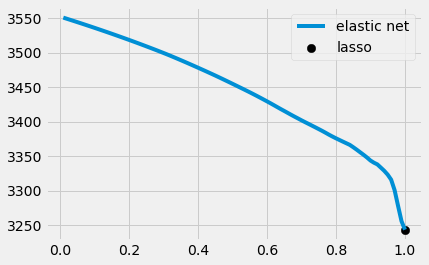

In [49]:
fig, ax = plt.subplots()

lasso = Lasso(alpha=10, random_state=42)
lasso.fit(X_train_processed, y_train)
lasso_pred = lasso.predict(X_test_processed[0].reshape(1, -1))

ax.plot(ratios, preds, label='elastic net')
ax.scatter(1, lasso_pred, c='k', s=70, label='lasso')
plt.legend();

#### Note on `ElasticNet()`

Is an Elastic Net with `l1_ratio` set to 0 equivalent to the ridge? In theory yes. But in practice no. It looks like the `ElasticNet()` predictions on the first test data point as `l1_ratio` shrinks are tending toward some value just above 3700. Let's check to see what prediction `Ridge()` gives us:

In [50]:
ridge = Ridge(alpha=10, random_state=42)
ridge.fit(X_train_processed, y_train)
ridge.predict(X_test_processed[0].reshape(1, -1))[0]

3092.742107522181

If you check the docstring for the `ElasticNet()` class you will see:
- that the function being minimized is slightly different from what we saw above; and
- that the results are unreliable when `l1_ratio` $\leq 0.01$.

**Exercise**: Visualize the difference in this case between `ElasticNet(l1_ratio=0.01)` and `Ridge()` by making a scatterplot of each model's predicted values for the first ten points in `X_test_processed`. Use `alpha=10` for each model. This plot should have the integers 1-10 on the x-axis, and the prediction values on the y-axis.

        Level Up: Make a second scatterplot that compares the predictions on the same data
        points between ElasticNet(l1_ratio=1) and Lasso().

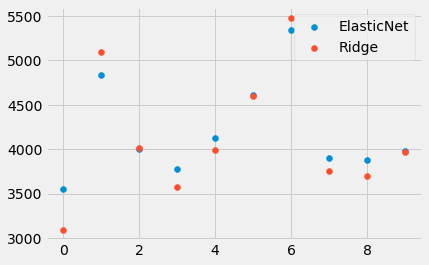

In [54]:
fig, ax = plt.subplots()
enet_r = ElasticNet(alpha=10, l1_ratio = 0.01, random_state = 42)
enet_r.fit(X_train_processed, y_train)
preds_enr = enet_r.predict(X_test_processed[:10])

preds_ridge = ridge.predict(X_test_processed[:10])

ax.scatter(np.arange(10), preds_enr, label = 'ElasticNet')
ax.scatter(np.arange(10), preds_ridge, label = 'Ridge')
plt.legend();

### Fitting Regularized Models with Cross-Validation

Our friend `sklearn` also includes tools that fit regularized regressions *with cross-validation*: `LassoCV`, `RidgeCV`, and `ElasticNetCV`.

**Exercise**: Use `RidgeCV` to fit a seven-fold cross-validated ridge regression model to our `X_train_processed` data and then calculate $R^2$ and the RMSE (root-mean-squared error) on our test set.

In [55]:
rcv = RidgeCV(cv=7)
rcv.fit(X_train_processed, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=7)

In [56]:
rcv.score(X_test_processed, y_test)

0.8380772934500291

In [57]:
np.sqrt(mean_squared_error(y_test, rcv.predict(X_test_processed)))

313.0570268253131

In [58]:
rcv.alpha_

10.0

# Using IC scores

IC scores are a probabilistic way of model and feature selection.

IC scores tend to favor models that are slightly underfit and heavily penalize models as their complexity increases (as the complexity increases the likelihood of them being overfit also increases).

When your sample size is too small for cross validation IC scores can be used to 

In [59]:
def aic(n_samples, k, error, y):
    return n_samples * error / np.var(y) + k

def bic(n, k, error):
    return n * np.log(error/n) + k * np.log(n)

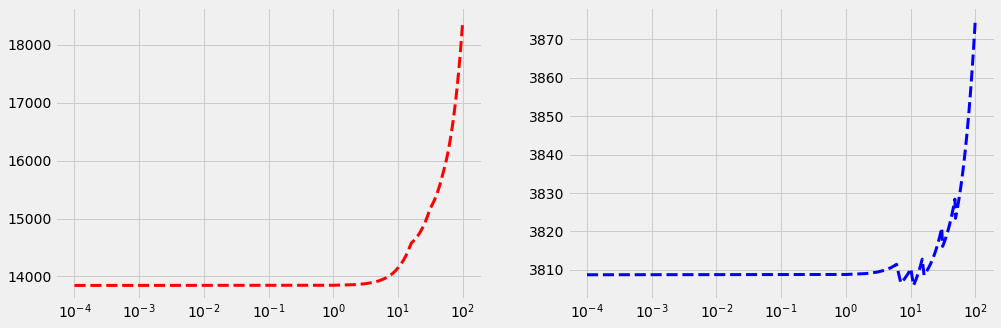

In [60]:
alphas = np.linspace(.0001,100,num=100)
aic_scores = []
bic_scores = []

full_ohe = OneHotEncoder(drop='first')
dummies = full_ohe.fit_transform(X[['species', 'island', 'sex']])
dummies_df = pd.DataFrame(dummies.todense(), columns=full_ohe.get_feature_names(),
                         index=X.index)

X_ohe = pd.concat([X[['bill_length_mm', 'bill_depth_mm',
                                'flipper_length_mm']], dummies_df], axis=1)


ss = StandardScaler()

X_trans = ss.fit_transform(X_ohe)

for alpha in alphas:
    rr = Lasso(alpha=alpha, random_state=42)
    rr.fit(X_trans, y)
    preds = rr.predict(X_trans)
    sse = ((y-preds)**2).sum()
    k = sum([1 for x in rr.coef_ if round(abs(x), 5) > 0])
    aic_scores.append(aic(X_trans.shape[0], k, sse, y))
    bic_scores.append(bic(len(X_trans), k, sse))
    

fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].semilogx(alphas, aic_scores, '--', color='red',
                 linewidth=3, label='AIC')
axes[1].semilogx(alphas, bic_scores, '--', color='blue',
                 linewidth=3, label='BIC');

### Using Sklearn

Text(0.5, 1.0, 'Information-criterion for model selection')

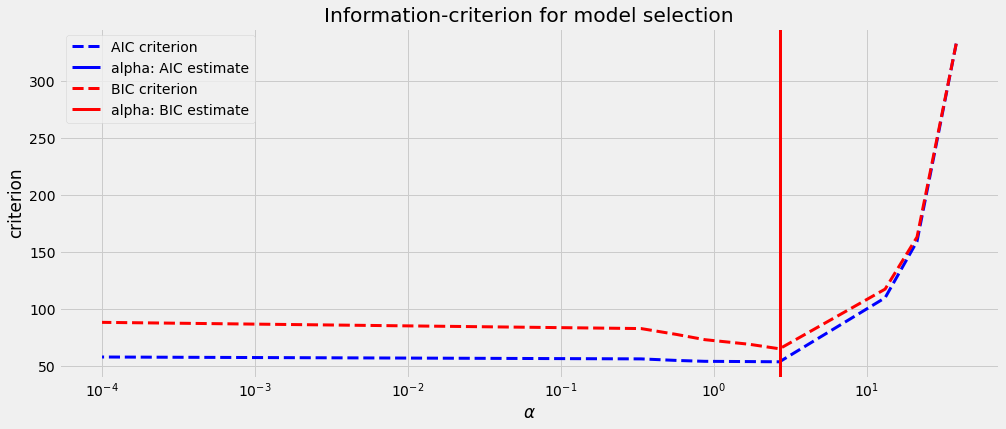

In [61]:
from sklearn.linear_model import LassoLarsIC
def plot_ic_criterion(model, name, color):
    criterion_ = model.criterion_
    plt.semilogx(model.alphas_ + EPSILON, criterion_, '--', color=color,
                 linewidth=3, label='%s criterion' % name)
    plt.axvline(model.alpha_ + EPSILON, color=color, linewidth=3,
                label='alpha: %s estimate' % name)
    plt.xlabel(r'$\alpha$')
    plt.ylabel('criterion')

EPSILON = 1e-4
model_bic = LassoLarsIC(criterion='bic')
model_bic.fit(X_trans, y)
alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(X_trans, y)
alpha_aic_ = model_aic.alpha_

plt.figure(figsize=(15,6))
plot_ic_criterion(model_aic, 'AIC', 'b')
plot_ic_criterion(model_bic, 'BIC', 'r')
plt.legend()
plt.title('Information-criterion for model selection')

In [62]:
model_aic.alpha_

2.6896719832170395